In [1]:
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
import numpy as np
import matplotlib.pyplot as plt

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    print(p, '/', l)

In [175]:
# load FISP pulse sequence
seq = Sequence(SEQUENCE_DIR+'FISP.py')

# load relevant global variables
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')

g_read = np.array([0, 0, 1]) # read gradient vector (values between -1 and 1, inclusive)

# set parameters for a 1D GRE image
seq.setpar(
    # FISP is generally designed for low angle pulses,
    # but we will use pulse settings for a 90 degree pulse for simplicity
    a_pulse=0.25,
    t_pulse=32e-6,
    
    # prephase for the read pulse, normalize for full amplitude
    g_phase_read=-g_read/np.linalg.norm(g_read),
    
    t_dw=1e-6,
    n_samples=1000,
    g_read=g_read,
    
    # normally with FISP we would have very short rep time and use leading pulses to reach steady state
    # but here we will use a long t_end and no leading pulses
    t_end=0.5,
    n_leading_pulses=0,
    n_scans=4
)

# set t_read to fit around the acquisition
seq.setpar(t_read=(seq.par.t_dw*seq.par.n_samples))
# set t_phase_read to to achieve half the gradient area of the read gradient pulse
seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_read))*seq.par.t_read/2)

# print out the parameter set for reference
print(seq.par)

# run sequence, progress_handler is optional
y = await seq.run(progress_handler=print_progress)

ParameterSet(n_scans=4, f=15091502.70579668, a_pulse=0.25, t_pulse=3.2e-05, n_leading_pulses=0, t_dw=1e-06, n_samples=1000, t_read=0.001, g_read=array([0., 0., 1.]), t_spoil=0.0001, g_spoil=array([0., 0., 0.]), t_phase=0.0005, g_phase_read=array([ 0.,  0., -1.]), n_phase_1=1, g_phase_1=array([0., 0., 0.]), n_phase_2=1, g_phase_2=array([0., 0., 0.]), t_grad_stab=0.0001, t_end=0.5, shim_x=0.18399363695583978, shim_y=0.18205330159470795, shim_z=-0.4567334173143255, shim_z2=-0.21283503889017835, shim_zx=-0.45566500428582535, shim_zy=0.06292884647672894, shim_xy=0.031063959953986156, shim_x2y2=0.2780328598595331)
1 / 4
2 / 4
3 / 4
4 / 4


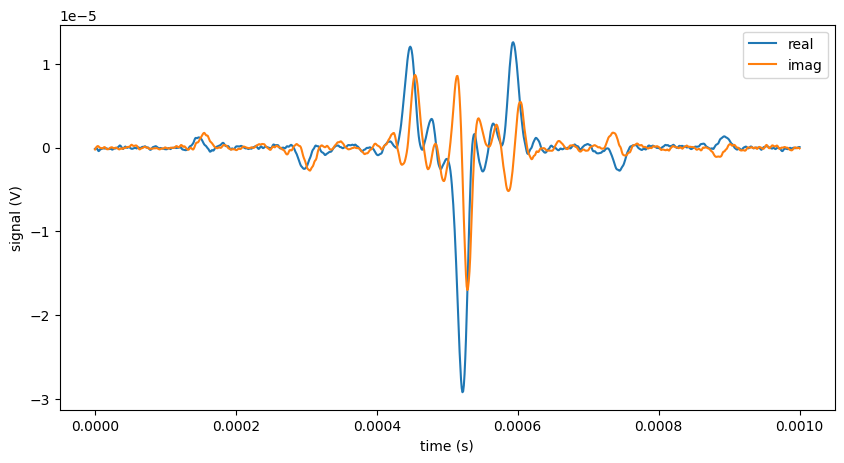

In [176]:
t = np.linspace(0, seq.par.n_samples*seq.par.t_dw, seq.par.n_samples)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(t, y.real, label='real')
plt.plot(t, y.imag, label='imag')
plt.ylabel('signal (V)')
plt.xlabel('time (s)')
plt.legend()
plt.show()

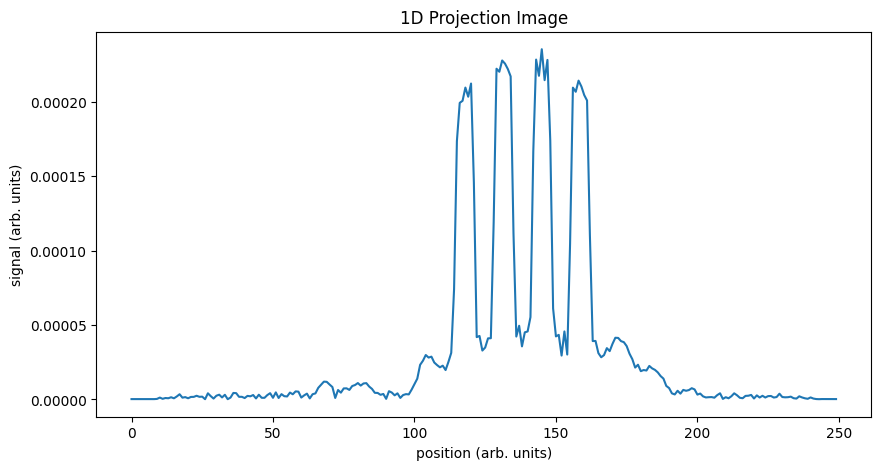

In [177]:
# The above data is the raw data from the hardware DSP, which does not have a flat frequency response
# to correct for it, oversample and use the decimate function in matipo.util.decimation
# an oversampling factor of 4 is recommended
y_dec = decimate(y, 4)
image = np.fft.fftshift(np.fft.fft(y_dec))

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.abs(image))
plt.ylabel('signal (arb. units)')
plt.xlabel('position (arb. units)')
plt.title('1D Projection Image')
plt.show()